<a href="https://colab.research.google.com/github/Susanarias/ecoiii-tarea3/blob/main/1_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**TAREA 3 - ECONOMETRÍA III**

Alumnas:

Arias Chavez Susana

Guevara Julca Marie

Ocon Tovar Sara



**INTRODUCCIÓN:**
**Split train and test**
Es una técnica común utilizada para evaluar el rendimiento de un modelo predictivo o algoritmo. Esta técnica implica dividir un conjunto de datos en dos subconjuntos distintos:

  *Conjunto de entrenamiento (train): Se emplea un conjunto de datos para enseñar
al modelo las relaciones y patrones que existen en los datos y así que el modelo pueda aprender hacer predicciones o clasificaciones precisas. Entonces podemos decir que el conjunto de entrenamiento es esencial para el proceso de entrenamiento y ajuste del modelo.

  *Conjunto de prueba (test): Es utilizado para evaluar el rendimiento del modelo sin haber visto previamente los datos durante el entrenamiento.

En conclusión, esta técnica permite evaluar y validar modelos de aprendizaje automático y garantizar su capacidad de generalización a nuevos datos.

Dicho esto, en adelante se utilizará esta técnica:

Para ello se va a dividir el conjunto de datos en conjuntos de datos de entrenamiento y de prueba,
  *Conjunto de datos de entrenamiento, desde la fecha de inicio hasta los últimos 30 días.
  *Conjunto de datos de prueba, desde los últimos 30 días hasta el final del conjunto de datos.
Dejaremos que el modelo haga previsiones basadas en los últimos 30 días y repetiremos el experimento 10 veces. Puede aumentarlo localmente si lo desea, y afinar los parámetros le ayudará mucho.




**DEFINICIÓN DE CÓDIGOS**

1. #_ _init_ _  es un método para definir los hiperpárametros del modelo
2. #lstm_cell, para crear una celda LSTM
3. #rnn_cells, se crea a partir de la pila de celdas LSTM
4. #Placeholders, nos permite definir dos tensores de marcador de posición para representar los datos de entrada y las etiquetas de salida
5. #Dropout, se aplica al conjunto de celdas RNN para regularizar el modelo y evitar el sobreajuste
6. #self.hidden_layer, representa el estado oculto inicial
7. #tf.train.AdamOptimizer, permite minimizar el costo durante el entrenamiento, su objetivo es ajustar los parámetros del modelo para que las predicciones se aproximen a las etiquetas reales.
8. #forecast(), es una función que  sirve para entrenar un modelo de pronóstico de series temporales y hacer predicciones futuras en base a ese modelo
9. #total_loss, se registran las pérdidas durante el entrenamiento
10. #total_acc, se registran las precisión durante el entrenamiento



In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [ ]:
df = pd.read_csv('GOOG_dataset.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-10-10,99.849998,99.989998,97.870003,98.709999,98.709999,16529900
1,2022-10-11,98.250000,100.120003,97.250000,98.050003,98.050003,21617700
2,2022-10-12,98.269997,99.648003,97.669998,98.300003,98.300003,17343400
3,2022-10-13,95.930000,100.529999,95.269997,99.709999,99.709999,32812200
4,2022-10-14,100.625000,101.290001,97.029999,97.180000,97.180000,22624800


In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.271737
1,0.259954
2,0.264417
3,0.289591
4,0.244421


In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((251, 7), (221, 1), (30, 1))

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [ ]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [ ]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:

train loop: 100%|██████████| 300/300 [04:11<00:00,  1.19it/s, acc=96.6, cost=0.00249]


simulation 2


train loop: 100%|██████████| 300/300 [04:55<00:00,  1.01it/s, acc=96.8, cost=0.00226]


simulation 3


train loop: 100%|██████████| 300/300 [04:52<00:00,  1.02it/s, acc=96.3, cost=0.00295]


simulation 4


train loop: 100%|██████████| 300/300 [04:59<00:00,  1.00it/s, acc=95.8, cost=0.00398]


simulation 5


train loop: 100%|██████████| 300/300 [04:06<00:00,  1.22it/s, acc=96.6, cost=0.00267]


simulation 6


train loop: 100%|██████████| 300/300 [04:17<00:00,  1.17it/s, acc=96.3, cost=0.00296]


simulation 7


train loop: 100%|██████████| 300/300 [04:06<00:00,  1.22it/s, acc=96.7, cost=0.00239]


simulation 8


train loop: 100%|██████████| 300/300 [04:30<00:00,  1.11it/s, acc=96.1, cost=0.00337]


simulation 9


train loop: 100%|██████████| 300/300 [05:05<00:00,  1.02s/it, acc=96.2, cost=0.00332]


simulation 10


train loop: 100%|██████████| 300/300 [05:08<00:00,  1.03s/it, acc=96.5, cost=0.00281]


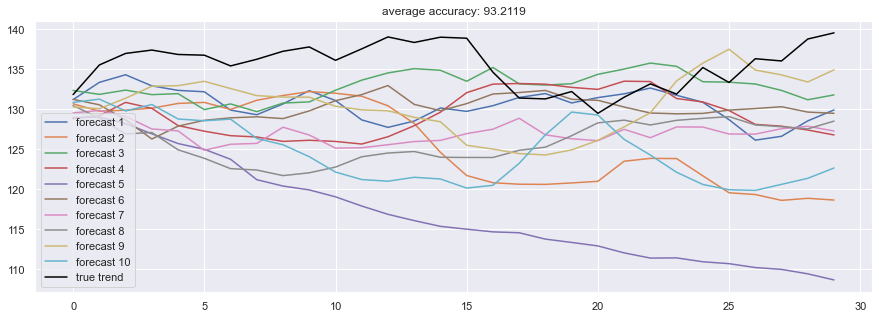

In [ ]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()

El modelo LSTM desarrollado nos ha permitido realizar una predicción del precio de cierre de las acciones de Google (GOOG) utilizando un modelo de red neuronal recurrente (RNN) con celdas LSTM (Long Short-Term Memory). El resultado final del código es un gráfico que muestra las predicciones del modelo, así como la verdadera tendencia del precio de cierre. En base a ello, se presenta las siguientes conclusiones:

El promedio de precisión es de 93.2119 : Ello nos infiere que las predicciones promedio del modelo en todas las simulaciones tienen un alto nivel de confianza, y el modelo tiene capacidad para predecir el precio de cierre.
En líneas generales, se presenta una similitud entre las simulaciones y la linea de tendencia real. Especificamente, es en los últimos períodos donde el modelo alcanza la mayor capacidad de predicción de los precios de cierre.